In [6]:
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from obspy import UTCDateTime
from scipy.signal import butter, sosfiltfilt, detrend




freq0 = 1.0
corr_len = 2
std_model = 0.004

posterior_cm = {}

for freq0 in [0.25, 0.5, 1.0]:
    infile = glob.glob(
        f'/home/pm/Documents_sync/PhD/StHelens/spatial/linearised/posterior_covariance_2_std0.004/{freq0}-*/posterior.npz')[0]

    outfolder = os.path.join(os.path.dirname(os.path.dirname(infile)), 'figures')
    os.makedirs(outfolder, exist_ok=True)

    loaded = np.load(infile)

    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    posterior_cm[freq0] = loaded['posterior']


utcs = [UTCDateTime(tt) for tt in t]
datetimes = [utci.datetime for utci in utcs]

4e-06


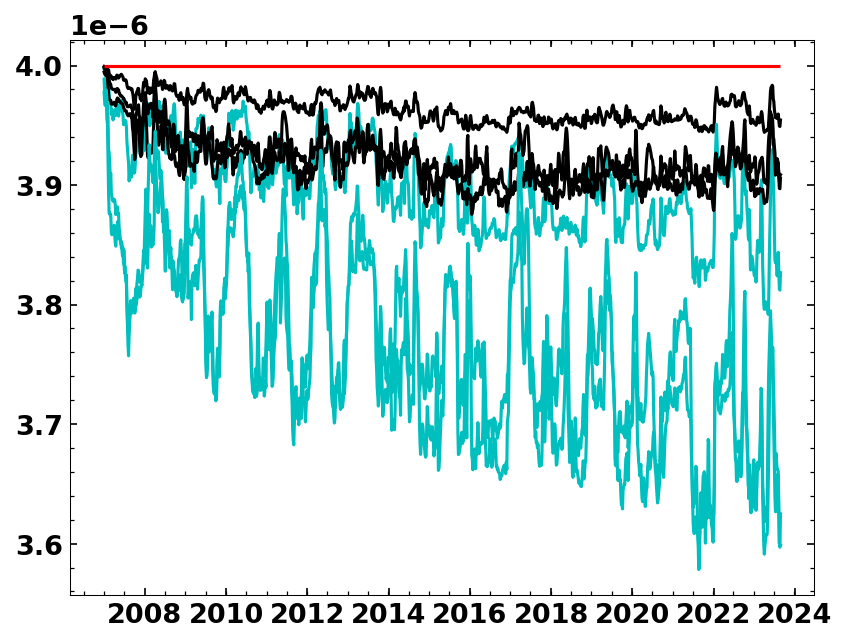

In [14]:
from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

m = posterior_cm[freq0].shape[0]-4
n = posterior_cm[freq0].shape[1]//2

m2, n2 = 15, 19

for freq0 in [0.25, 0.5, 1.0]:
    plt.plot(datetimes, posterior_cm[freq0][m, n, :], color='k', label=f'{freq0} Hz')
    plt.plot(datetimes, posterior_cm[freq0][m2, n2, :], color='c', label=f'{freq0} Hz')
plt.hlines((4e-3*1/2)**2, datetimes[0], datetimes[-1], color='r', label='Prior Covariance')

In [15]:
# map view
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt

lat0 = 46.05
lat = km2d(y) + lat0
lat0 = lat.min()
lon0 = -122.45 # -122.34
# find out how many degree 1km is
km2lon = 1/d2km(loc2d(lat0, 1, lat0, 0))
lon = km2lon*(x-x.min())+lon0

region = [lon.min(), lon.max(), lat.min(), lat.max()]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region)
# topo is returned as lines are latitude and columns longitude


pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -122.022384584 to -122.021666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.3647625621 to 46.365


In [41]:
from scipy.interpolate import RegularGridInterpolator

posterior_cm_grids = {}

latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data


lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])

for freq0 in [0.25, 0.5, 1.0]:
    f = RegularGridInterpolator((lat, lon), posterior_cm[freq0][..., 514], bounds_error=False, method='linear')

    posterior_cmint = f(qcoords)
    posterior_cmint = posterior_cmint.reshape(latqg.shape)

    posterior_cm_grid = DataArray(data=posterior_cmint, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='posterior')
    posterior_cm_grids[freq0] = posterior_cm_grid


In [42]:
print(np.argmin(posterior_cm_grids[0.5].data))
print(posterior_cm_grids[0.5].data.shape)

514
(381, 516)


In [45]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()

persp = [180, 90] #40

proj = "M30c"


surftype = 'i'

for freq0 in [0.25, 0.5, 1.0]:
    pygmt.makecpt(
        # cmap="red,white,blue",
        cmap='batlow',
        series=f"3.6e-6/4e-6",
        continuous=True,
        reverse=False,
        )
    with pygmt.config(
        MAP_FRAME_TYPE='fancy+',
            FONT='25p,Helvetica-Bold'):
        dgrid = pygmt.grdgradient(grid=topo, radiance=[270, 1])
        # add contour lines
        
        fig.grdimage(
            grid=posterior_cm_grids[freq0],
            # Sets the view azimuth as 130 degrees, and the view elevation as 30
            # degrees
            perspective=persp, #160 50
            region=region,
            # Sets the x- and y-axis labels, and annotates the west, south, and east
            # axes
            # frame=["xa", "ya", "WSnE"],
            frame='a',
            # shading=dgrid,
            # surftype='sm',#m0.01p',
            # cmap='rainbow',
            # plane="2000+gblack",
            # Sets a Mercator projection on a 15-centimeter figure
            projection=proj,
            # Sets the height of the three-dimensional relief centimeters
            # meshpen="0,150",
            transparency=30,
            interpolation='n',
            cmap=True
        )
        fig.grdcontour(
            annotation=500,
            interval=250,
            grid=topo,
        )
        fig.colorbar(frame=[f'a'], projection=proj)
        fig.plot(
            x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, projection=proj)
        # plot st helens seismic zone
        fig.plot(
            # region=[0, 10, 0, 10],
            # projection="X15c/10c",
            # frame="a",
            x=[-122.19, -122.26],
            y=[46.21, 46.4],
            pen="1.5p,black",
        )
        # plot a box around the pixel areas around m and n
        # and fill it
        # fig.plot(
        #     x=[lon[n], lon[n], lon[n+1], lon[n+1], lon[n]],
        #     y=[lat[m], lat[m+1], lat[m+1], lat[m], lat[m]],
        #     pen="1.5p,black", color="black", transparency=50,
        # )
        # fig.plot(
        #     x=[lon[n2], lon[n2], lon[n2+1], lon[n2+1], lon[n2]],
        #     y=[lat[m2], lat[m2+1], lat[m2+1], lat[m2], lat[m2]],
        #     pen="1.5p,black", color="cyan", transparency=50,
        # )
        fig.text(text='SHZ', angle=-72, x=-122.225, y=46.32, font='Helvetica-Bold', justify='LM', offset='0.2c')
    fig.savefig(f'{outfolder}/posteriorcm_{freq0}-{freq0*2}.png', dpi=300, transparent=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
